In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import warnings
warnings.filterwarnings("ignore")

#### Data Description
**All values are the price of the stock at close time, in dollars $ from 1994 to 2018**
 - 'ftse' is a share index of the top 100 companies listed on the London Stock Exchange

In [2]:
raw_csv_data = pd.read_csv("datasets/ftse.csv")                           #reading the csv file
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)   #converting to date format
df_comp.set_index("date", inplace=True)                        #Setting the DataFrame index using existing date columns
df_comp=df_comp.fillna(method="ffill")                         #filling space as Null

In [3]:
df_comp

,market_value
date,
1994-01-07,3445.980000
1994-01-10,3440.580000
1994-01-11,3413.770000
1994-01-12,3372.020000
1994-01-13,3360.010000
...,...
2018-01-23,7731.827774
2018-01-24,7643.428966
2018-01-25,7615.839954


In [4]:
size = int(len(df_comp)*0.8)                               #spliting train test data
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]   

In [5]:
#Creating Returns
df['returns'] = df.market_value.pct_change(1)*100  #Percentage change between the current and a prior element
df_test['returns'] = df_test.market_value.pct_change(1)*100
#Creating Squared Returns
df['sq_returns'] = df.returns.mul(df.returns)

In [6]:
#Test for stationary
from statsmodels.tsa.stattools import adfuller
def adfuller_test(ts):
    adfuller_result = adfuller(ts,autolag=None)
    adfuller_out=pd.Series(adfuller_result[0:4],index=['Test Statistic','p-value','Lags Used','Number of observations Used'])
    print(adfuller_out)
adfuller_test(df.returns[1:])

Test Statistic                -1.278422e+01
p-value                        7.305352e-24
Lags Used                      3.200000e+01
Number of observations Used    4.981000e+03
dtype: float64


#### The p-value is lesser than 0.05 so we say that the data is stationary

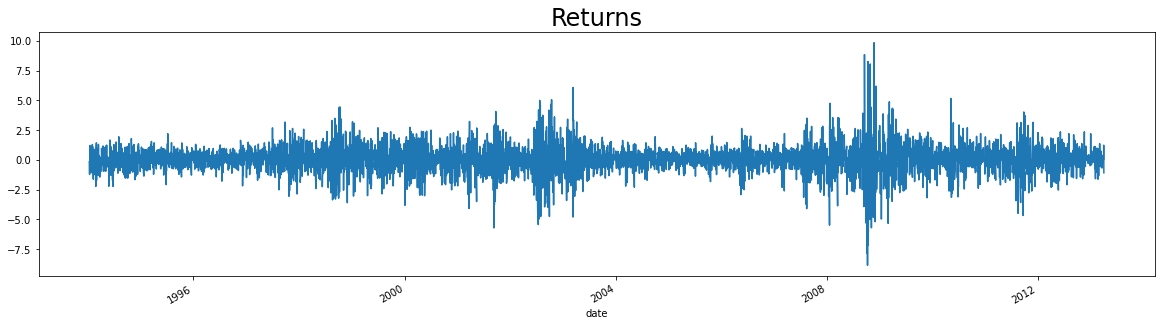

In [7]:
#Returns vs Squared Returns
df.returns.plot(figsize=(20,5))
plt.title("Returns", size = 24)
plt.show()

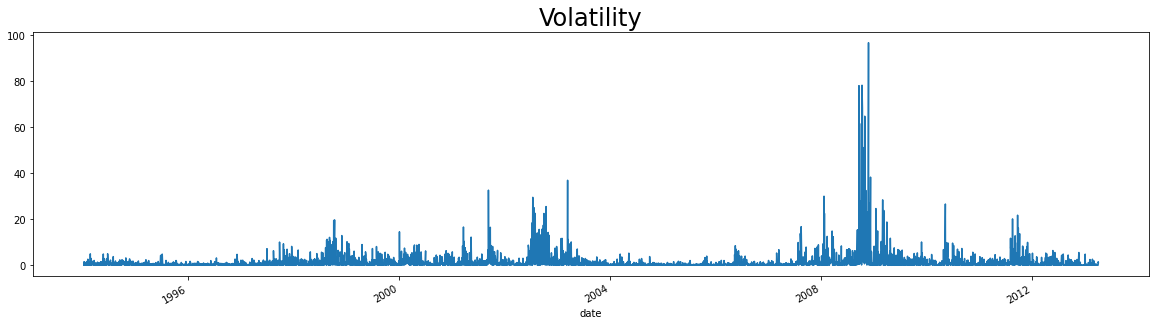

In [8]:
df.sq_returns.plot(figsize=(20,5))
plt.title("Volatility", size = 24)
plt.show()

#### Between 2004 and 2006, the market returns has no significant variance so the volatility for that period is low.

#### The jumps and drops are high in period 2008 to 2010 so we can see huge peak in volatility.

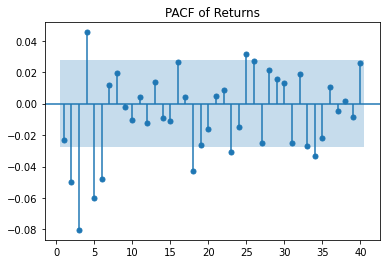

In [9]:
sgt.plot_pacf(df.returns[1:], lags = 40, zero = False)
plt.title("PACF of Returns")
plt.show()

#### We can see several lags which are significant in the above graph. We will square the values and check again.

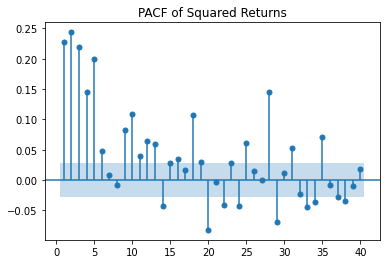

In [10]:
sgt.plot_pacf(df.sq_returns[1:], lags = 40, zero = False)
plt.title("PACF of Squared Returns")
plt.show()

#### We can see first 6 lags are significant. High values signifies that there is huge short term trends in variance.

In [11]:
from arch import arch_model
model_arch_1 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 1)
results_arch_1 = model_arch_1.fit()
results_arch_1.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 28798.757001180536
Iteration:      2,   Func. Count:     13,   Neg. LLF: 12050.749558904736
Iteration:      3,   Func. Count:     20,   Neg. LLF: 7799.7925599088085
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7651.690850735368
Iteration:      5,   Func. Count:     30,   Neg. LLF: 7651.690841351308
Iteration:      6,   Func. Count:     33,   Neg. LLF: 7651.690841351348
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7651.690841351308
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7651.69
Distribution:                  Normal   AIC:                           15309.4
Method:            Maximum Likelihood   BIC:                           15328.9
                                        No. Observations:                 5014
Date:                Fri, Jan 28 2022   Df Residuals:                     5013
Time:                        21:58:37   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0344  1.602e-02      2.150  3.157e-02 [3.041e-03,6.585e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9192  4.320e-02     21.277 1.841e-100 [  0.835,  1.004]
alpha[1]       0.3707  5.078e-02      7.301  2.853e-13 [  0.271,  0.470]
========================================================================

Covariance estimator: robust
"""

#### The python took only 6 steps to resolve so it is a simple model. The R-squared is zero because it cannot explain the variation from the mean and the residual values doent change by a constant. it is not used in ARCH model. The p-value is lesser than 0.05 for mu, omega and alpha[1] so we can say that all 3 co-efficients are significant 

In [12]:
model_arch_2 = arch_model(df.returns[1:], mean = "Zero", vol = "ARCH", p = 1)
results_arch_2 = model_arch_2.fit()
results_arch_2.summary()

Iteration:      1,   Func. Count:      4,   Neg. LLF: 11604.311744959507
Iteration:      2,   Func. Count:     10,   Neg. LLF: 7804.970330062723
Iteration:      3,   Func. Count:     15,   Neg. LLF: 7654.533260279932
Iteration:      4,   Func. Count:     18,   Neg. LLF: 7654.533254505231
Iteration:      5,   Func. Count:     20,   Neg. LLF: 7654.533254505253
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7654.533254505231
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7654.53
Distribution:                  Normal   AIC:                           15313.1
Method:            Maximum Likelihood   BIC:                           15326.1
                                        No. Observations:                 5014
Date:                Fri, Jan 28 2022   Df Residuals:                     5014
Time:                        21:58:37   Df Model:                            0
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9229  4.343e-02     21.251 3.193e-100 [  0.838,  1.008]
alpha[1]       0.3665  4.984e-02      7.353  1.945e-13 [  0.269,  0.464]
========================================================================

Covariance estimator: robust
"""

#### We keep mean zero and we could find that mean model isn't showed in summary and the log-likelihood is slightly lesser than mean constant model. 

In [13]:
model_arch_3 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch_3 = model_arch_3.fit()
results_arch_3.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34209.2429534143
Iteration:      2,   Func. Count:     15,   Neg. LLF: 11077.83697973076
Iteration:      3,   Func. Count:     24,   Neg. LLF: 7917.171941594852
Iteration:      4,   Func. Count:     31,   Neg. LLF: 7632.849360365768
Iteration:      5,   Func. Count:     37,   Neg. LLF: 9450.586774626132
Iteration:      6,   Func. Count:     44,   Neg. LLF: 7440.401673427719
Iteration:      7,   Func. Count:     49,   Neg. LLF: 7440.4013432982265
Iteration:      8,   Func. Count:     54,   Neg. LLF: 7440.401321890164
Iteration:      9,   Func. Count:     58,   Neg. LLF: 7440.4013218901455
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7440.401321890164
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7440.40
Distribution:                  Normal   AIC:                           14888.8
Method:            Maximum Likelihood   BIC:                           14914.9
                                        No. Observations:                 5014
Date:                Fri, Jan 28 2022   Df Residuals:                     5013
Time:                        21:58:37   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0488  1.401e-02      3.481  5.001e-04 [2.130e-02,7.622e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6960  3.569e-02     19.502  1.060e-84 [  0.626,  0.766]
alpha[1]       0.2214  3.493e-02      6.339  2.306e-10 [  0.153,  0.290]
alpha[2]       0.2791  3.643e-02      7.663  1.813e-14 [  0.208,  0.351]
========================================================================

Covariance estimator: robust
"""

#### Now we increased the lag by 1 and we get a extra coefficient so the model runs 9 iteration so we can say it gets little complex when u increase the lags.

#### The log-likelihood increase so we say that this model is better than previous model

#### We repeat the ARCH model as increasing the lags and we find that the log-likelihood increases. This is trial and error so we need to run multiple times to find the suitable lag. We need to stop when the model log-likelihood doesnt increase significantly

In [14]:
model_arch_4 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 15)
results_arch_4 = model_arch_4.fit()
results_arch_4.summary()

Iteration:      1,   Func. Count:     19,   Neg. LLF: 121286.13354692188
Iteration:      2,   Func. Count:     41,   Neg. LLF: 2571994.14026259
Iteration:      3,   Func. Count:     60,   Neg. LLF: 64510.81817862583
Iteration:      4,   Func. Count:     79,   Neg. LLF: 8810.052629531001
Iteration:      5,   Func. Count:    100,   Neg. LLF: 10050.702879007553
Iteration:      6,   Func. Count:    120,   Neg. LLF: 23477.144487758764
Iteration:      7,   Func. Count:    140,   Neg. LLF: 13699.63162819725
Iteration:      8,   Func. Count:    160,   Neg. LLF: 9316.801883812586
Iteration:      9,   Func. Count:    180,   Neg. LLF: 8947.293743860275
Iteration:     10,   Func. Count:    200,   Neg. LLF: 9432.941441775602
Iteration:     11,   Func. Count:    220,   Neg. LLF: 7653.270298892905
Iteration:     12,   Func. Count:    240,   Neg. LLF: 7645.705722977408
Iteration:     13,   Func. Count:    260,   Neg. LLF: 8028.430013762863
Iteration:     14,   Func. Count:    280,   Neg. LLF: 7218.269

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6972.20
Distribution:                  Normal   AIC:                           13978.4
Method:            Maximum Likelihood   BIC:                           14089.2
                                        No. Observations:                 5014
Date:                Fri, Jan 28 2022   Df Residuals:                     5013
Time:                        21:58:37   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0502  1.203e-02      4.169  3.060e-05 [2.659e-02,7.376e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1806  2.251e-02      8.021  1.045e-15      [  0.136,  0.225]
alpha[1]       0.0587  1.759e-02      3.337  8.464e-04  [2.423e-02,9.319e-02]
alpha[2]       0.1147  2.025e-02      5.661  1.503e-08    [7.496e-02,  0.154]
alpha[3]       0.1255  2.587e-02      4.851  1.231e-06    [7.478e-02,  0.176]
alpha[4]       0.0813  2.209e-02      3.680  2.330e-04    [3.800e-02,  0.125]
alpha[5]       0.0691  1.726e-02      4.000  6.322e-05    [3.522e-02,  0.103]
alpha[6]       0.0836  1.941e-02      4.308  1.650e-05    [4.557e-02,  0.122]
alpha[7]       0.0410  1.867e-02      2.197  2.805e-02  [4.417e-03,7.759e-02]
alpha[8]       0.0630  1.853e-02      3.399  6.761e-04  [2.667e-02,9.931e-02]
alpha[9]       0.0258  1.702e-02      1.517      0.129 [-7.545e-03,5.917e-02]
alpha[10]      0.0271  1.572e-02      1.726  8.437e-02 [-3.680e-03,5.796e-02]
alpha[11]      0.0731  1.766e-02      4.142  3.438e-05    [3.854e-02,  0.108]
alpha[12]      0.0400  1.902e-02      2.104  3.537e-02  [2.742e-03,7.730e-02]
alpha[13]      0.0371  1.439e-02      2.582  9.836e-03  [8.945e-03,6.535e-02]
alpha[14]  9.3411e-03  1.465e-02      0.637      0.524 [-1.938e-02,3.806e-02]
alpha[15]      0.0268  1.359e-02      1.968  4.909e-02  [1.062e-04,5.340e-02]
=============================================================================

Covariance estimator: robust
"""

#### when we increase the lags by 15 we get more insignificant coefficients like alpha[9], alpha[10] and alpha[14] where the p-value is greater than 0.05, So we stop our model in 8 lags

In [15]:
model_arch_5 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 8)
results_arch_5 = model_arch_5.fit()
results_arch_5.summary()

Iteration:      1,   Func. Count:     12,   Neg. LLF: 185086.25744324407
Iteration:      2,   Func. Count:     27,   Neg. LLF: 2203423.598129509
Iteration:      3,   Func. Count:     39,   Neg. LLF: 1969931.18759455
Iteration:      4,   Func. Count:     52,   Neg. LLF: 12032.160258261994
Iteration:      5,   Func. Count:     66,   Neg. LLF: 19373.847192096793
Iteration:      6,   Func. Count:     79,   Neg. LLF: 8452.112392985382
Iteration:      7,   Func. Count:     92,   Neg. LLF: 8051.439476723784
Iteration:      8,   Func. Count:    105,   Neg. LLF: 7663.301223190288
Iteration:      9,   Func. Count:    118,   Neg. LLF: 7236.849990908792
Iteration:     10,   Func. Count:    131,   Neg. LLF: 7248.666868130322
Iteration:     11,   Func. Count:    144,   Neg. LLF: 7650.80828494964
Iteration:     12,   Func. Count:    157,   Neg. LLF: 7226.913690061588
Iteration:     13,   Func. Count:    170,   Neg. LLF: 7117.124651884744
Iteration:     14,   Func. Count:    183,   Neg. LLF: 7123.6065

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7018.50
Distribution:                  Normal   AIC:                           14057.0
Method:            Maximum Likelihood   BIC:                           14122.2
                                        No. Observations:                 5014
Date:                Fri, Jan 28 2022   Df Residuals:                     5013
Time:                        21:58:38   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0554  1.177e-02      4.708  2.500e-06 [3.234e-02,7.847e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2427  2.256e-02     10.755  5.588e-27   [  0.198,  0.287]
alpha[1]       0.0712  1.844e-02      3.862  1.124e-04 [3.508e-02,  0.107]
alpha[2]       0.1286  2.024e-02      6.350  2.150e-10 [8.888e-02,  0.168]
alpha[3]       0.1461  2.620e-02      5.576  2.466e-08 [9.474e-02,  0.197]
alpha[4]       0.1093  2.158e-02      5.065  4.086e-07 [6.700e-02,  0.152]
alpha[5]       0.1165  1.886e-02      6.176  6.584e-10 [7.952e-02,  0.153]
alpha[6]       0.1235  1.989e-02      6.208  5.369e-10 [8.451e-02,  0.162]
alpha[7]       0.0707  1.989e-02      3.552  3.818e-04 [3.168e-02,  0.110]
alpha[8]       0.0717  1.763e-02      4.069  4.729e-05 [3.718e-02,  0.106]
==========================================================================

Covariance estimator: robust
"""

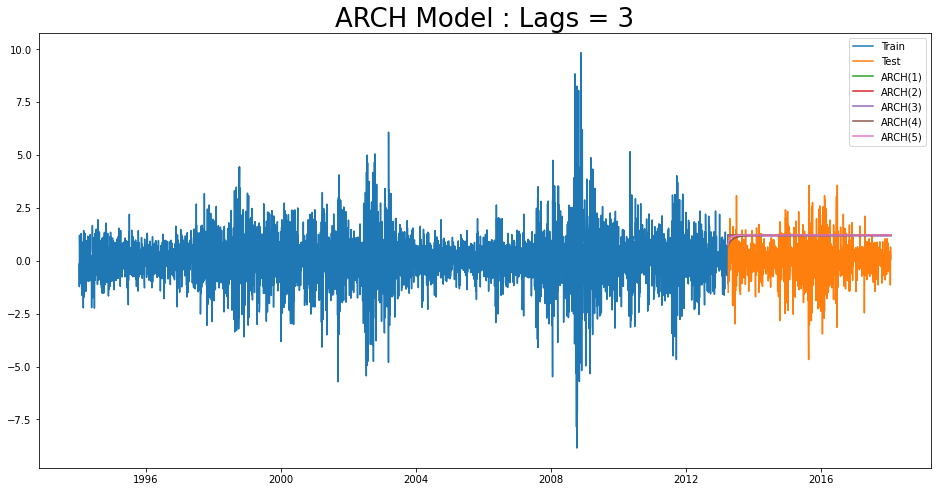

In [17]:
y_hat = df_test.copy()
predictions_1 = results_arch_1.forecast(horizon=df_test.shape[0])
predicted_array_1 = predictions_1.variance.values[-1:]
y_hat["ARCH(1)"] = np.sqrt(predicted_array_1.tolist()[0])
predictions_2 = results_arch_2.forecast(horizon=df_test.shape[0])
predicted_array_2 = predictions_2.variance.values[-1:]
y_hat["ARCH(2)"] = np.sqrt(predicted_array_2.tolist()[0])
predictions_3 = results_arch_3.forecast(horizon=df_test.shape[0])
predicted_array_3 = predictions_3.variance.values[-1:]
y_hat["ARCH(3)"] = np.sqrt(predicted_array_3.tolist()[0])
predictions_4 = results_arch_4.forecast(horizon=df_test.shape[0])
predicted_array_4 = predictions_4.variance.values[-1:]
y_hat["ARCH(4)"] = np.sqrt(predicted_array_4.tolist()[0])
predictions_5 = results_arch_5.forecast(horizon=df_test.shape[0])
predicted_array_5 = predictions_5.variance.values[-1:]
y_hat["ARCH(5)"] = np.sqrt(predicted_array_5.tolist()[0])
plt.figure(figsize=(16,8)) 
plt.plot( df['returns'], label='Train') 
plt.plot(df_test['returns'], label='Test') 
plt.plot(y_hat["ARCH(1)"], label="ARCH(1)") 
plt.plot(y_hat["ARCH(2)"], label="ARCH(2)")
plt.plot(y_hat["ARCH(3)"], label="ARCH(3)") 
plt.plot(y_hat["ARCH(4)"], label="ARCH(4)") 
plt.plot(y_hat["ARCH(5)"], label="ARCH(5)") 
plt.legend(loc='best') 
plt.title("ARCH Model : Lags = 3", size = 26)
plt.show()